In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import StaleElementReferenceException
import time as tm
import operator
from datetime import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import re
import pandas as pd
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

In [2]:
'''nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') '''

"nltk.download('stopwords')\nnltk.download('wordnet')\nnltk.download('punkt')\nnltk.download('averaged_perceptron_tagger') "

In [3]:
id_ = 'ENTER USERNAME'
password = 'ENTER PASSWORD'

In [4]:
def login():
    #change path of chrome driver here 
    driver = webdriver.Chrome('chromedriver')
    driver.maximize_window()
    link = 'https://www.instagram.com/'
    driver.get(link)

    #waiting until the site is loaded
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.NAME, 'username')))

    #finding element for username
    user = driver.find_element(By.NAME, 'username')
    #passing username into field
    user.send_keys(id_)

    #finding element for username
    pass_ = driver.find_element(By.NAME, 'password')
    #passing password into field
    pass_.send_keys(password)

    #finding element for login
    login = driver.find_element(By.XPATH, '//button[contains(@class , "_acan _acap _acas")]')
    login.click()

    #waiting till the 'save login' info screen appears
    try:
        wait = WebDriverWait(driver, 10)
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, '_aa55')))

        #denying to save password in browser
        if driver.find_element(By.CLASS_NAME, '_ac8f'):
            save_info = driver.find_element(By.CLASS_NAME, '_ac8f')
            save_info.click()

        tm.sleep(1)
    except TimeoutException:
        pass
    
    #waiting for popup
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, '_a9-v')))
    
    #denying notification turn on
    if driver.find_element(By.CLASS_NAME, '_a9-v'):
        deny_turn_noti = driver.find_element(By.XPATH,'//button[contains(@class, "_a9-- _a9_1")]')
        deny_turn_noti.click()
    return driver

In [5]:
# data is stored in such a way 
# d = {'username' : ['no_of_follower', 
# 'Likes on post 1', Likes on post 2', Likes on post 3' ---- Likes on post 10', 
# 'caption on post 1' ---- 'caption on post 10', no_of_post_done_in_last_3_days']}
def search_results(driver):
    
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.XPATH, '//div[contains(@class, "xh8yej3 x1iyjqo2")]/div[2]')))
    
    search_btn = driver.find_element(By.XPATH, '//div[contains(@class, "xh8yej3 x1iyjqo2")]/div[2]')
    search_btn.click()
    search_box = driver.find_element(By.CLASS_NAME, "_aauy")
    search_box.clear()
    search_box.send_keys('gaming')  
    
    
    tm.sleep(3)
    raw_search_results = driver.find_elements(By.XPATH, '//span[contains(@class, "x193iq5w xeuugli x1fj9vlw x13faqbe x1vvkbs xt0psk2 x1i0vuye xvs91rp x1s688f x5n08af x10wh9bi x1wdrske x8viiok x18hxmgj")]')

    usernames =  []
    #getting the links of users
    for i in raw_search_results:
        usernames.append(i.text)
    usernames = [x for x in usernames if x != '']
    
    #THIS IS THE DICTIONARY THAT IS RETURNED
    main_dict = {}
    link = 'https://www.instagram.com/'
    for i in usernames[:10]:
        main_list = []
        driver.get(link + i)     
        
        #THIS BLOCK COUNTS NUMBER OF FOLLOWERS OF USERNAME
        try:
            #section containing follower, post, following to be loaded
            wait = WebDriverWait(driver, 10)
            tm.sleep(1)
            wait.until(EC.presence_of_element_located((By.XPATH, '//span[@class = "_ac2a"]')))
            post_followerss_following_data = driver.find_elements(By.XPATH, '//span[@class = "_ac2a"]')[1].get_attribute('title')
            post_followerss_following_data = "".join(post_followerss_following_data.split(','))
            main_list.append(int(post_followerss_following_data))
            
            
            #once page is opened we will check
            #for any post present on profile
            try:
                #searching for recent post
                driver.find_element(By.XPATH, '//div[contains(@class, "_aabd _aa8k  _al3l")]/a').click()
                
                #getting current date time
                current_date = datetime.now()

                tm.sleep(1)
                #getting datetime for the first upload

                wait = WebDriverWait(driver, 10)
                
                #count of number of post
                
                
                #waiting for the time data to be loaded
                wait.until(EC.presence_of_element_located((By.XPATH , '//time[contains(@class, "_aaqe")]')))
                try:
                    time_ = driver.find_element(By.XPATH , '//time[contains(@class, "_aaqe")]').get_attribute('datetime')
                except StaleElementReferenceException:
                    tm.sleep(2)
                    time_ = driver.find_element(By.XPATH , '//time[contains(@class, "_aaqe")]').get_attribute('datetime')
                
                given_date = datetime.strptime(time_, "%Y-%m-%dT%H:%M:%S.000Z")
                
                
                likes_list= [] #likes of 10 post
                caption_list = [] #caption of 10 post
                post_in_last_3_days = 0 #freq of post in last 3 days
                
                for k in range(10):
                    if given_date  > (current_date - timedelta(days = 3)):
                        post_in_last_3_days += 1
                    
                    #waiting for likes to load
                    wait.until(EC.presence_of_element_located((By.XPATH , '//section[contains(@class, "_ae5m _ae5n _ae5o")]')))
                    #getting number of likes
                    likes = driver.find_element(By.XPATH, '//section[contains(@class, "_ae5m _ae5n _ae5o")]').text
                    #converting to int
                    #sometimes likes are not available in numbers
                    
                    try:
                        likes = int(''.join(filter(str.isdigit, likes)))
                    except ValueError:
                        likes = 0
                    likes_list.append(likes)
                    
                    
                    try:
                        wait = WebDriverWait(driver, 2)
                        #waiting for caption to be loaded
                        wait.until(EC.presence_of_element_located((By.XPATH , '//div[contains(@class, "_a9zs")]/h1[contains(@class , "_aacl _aaco _aacu _aacx _aad7 _aade")]')))
                        #scraping caption
                        caption = driver.find_element(By.XPATH, '//div[contains(@class, "_a9zs")]/h1[contains(@class , "_aacl _aaco _aacu _aacx _aad7 _aade")]').text
                        caption_list.append(str(caption))
                    
                    except TimeoutException:
                        #means no caption is there
                        caption_list.append('')
                    
                    try:
                        wait = WebDriverWait(driver, 2)
                        #waiting till the next button is loaded
                        wait.until(EC.presence_of_element_located((By.XPATH, '//div[contains(@class, " _aaqg _aaqh")]')))
                        next_ = driver.find_element(By.XPATH, '//div[contains(@class, " _aaqg _aaqh")]').click()
                    except TimeoutException:
                        #means this is the last post of the user
                        #move to the next username
                        for f in range(10-k-1):
                            likes_list.append(0)
                            caption_list.append('')
                        break
                main_list.append(likes_list)
                main_list.append(caption_list)
                main_list.append(post_in_last_3_days)
                
            #it means that no post are available on 
            #which means columns - 'post in last 3 days', 'likes --- 10 post', avg likes, 
            #and 'likes to follower ratio' will be zero
            except NoSuchElementException:
                main_list.append(0)
                continue
        
        #this means followers data is not available    
        except NoSuchElementException:
            main_list.append(0)
        
        main_dict[i] = main_list 
        
    
    #once done return to main page
    link = 'https://www.instagram.com/'
    driver.get(link)
    return main_dict

In [6]:
def get_csv(driver):
    d = search_results(driver)
    
    #preparing csv file
    columns = ['Username','No. of Followers', 'Likes on post1','Likes on post 2','Likes on post 3','Likes on post 4','Likes on post 5','Likes on post 6','Likes on post 7', 'Likes on post 8','Likes on post 9','Likes on post 10','Caption on post 1', 'Caption on post 2', 'Caption on post 3', 'Caption on post 4','Caption on post 5','Caption on post 6','Caption on post 7','Caption on post 8','Caption on post 9','Caption on post 10', 'Number of post in last 3 days', 'Avg likes(10 posts)', 'Avg. Likes to Followers Ratio']
    df = pd.DataFrame(columns = columns)
    df['Username'] = d.keys()
    df['No. of Followers'] = [x[0] for x in list(d.values())]
    df[['Likes on post1','Likes on post 2','Likes on post 3','Likes on post 4','Likes on post 5','Likes on post 6','Likes on post 7', 'Likes on post 8','Likes on post 9','Likes on post 10']] = [x[1] for x in list(d.values())]
    df[['Caption on post 1', 'Caption on post 2', 'Caption on post 3', 'Caption on post 4','Caption on post 5','Caption on post 6','Caption on post 7','Caption on post 8','Caption on post 9','Caption on post 10']] = [x[2] for x in list(d.values())]
    df['Number of post in last 3 days'] = [x[3] for x in list(d.values())]

    valid_columns = df.columns[2:13]
    df['Avg likes(10 posts)'] = df[valid_columns].mean(axis = 1).round()
    df['Avg. Likes to Followers Ratio'] = df['Avg likes(10 posts)']/df['No. of Followers']
    return df


In [7]:
def get_clean_text_hashtags(data):

    #return series of hashtags and their count
    #second dataframe of clean words and their frequency
    top_5_df = data.sort_values(by = 'No. of Followers', ascending = False)[:5]

    #getting hashtags
    captions_df = top_5_df.iloc[:, 12:22]


    #will contain all the captions posted by all the username in every post
    #as a single string
    main_text = ''

    for i in captions_df.columns:
        text_ = captions_df[i]
        for i in text_:
            #adding each text to main_text
            main_text += str(i)
        #print(text_)

    #finding word that starts with '#'
    hashtags = hashtags = re.findall(r'#\w+', main_text)
    #made np array
    hashtags = np.array(hashtags)
    #finding unique and their counts
    hashtags, counts = np.unique(hashtags, return_counts=True)
    #making series
    #THIS IS RETURNED
    final = pd.Series(counts , index = hashtags)

    # Tokenize the text into words
    tokens = word_tokenize(main_text)
    # Filter out stopwords and non-alphabetic words
    stop_words = set(stopwords.words('english'))

    words = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # Calculate word frequencies
    word_freq = Counter(words)
    #THIS IS RETURNED
    word_freq = dict(sorted(word_freq.items(), key = operator.itemgetter(1), reverse = True))
    return final, word_freq


In [11]:
def final_run():
    
    driver = login()
    #this is the main function
    #this scrapes data from instagram
    data = get_csv(driver)
    
    #getting hashtags and clean words frequency
    hashtags, word_freq_dict = get_clean_text_hashtags(data)
    
    #slicing data from top 5 username by number of followers
    data1 = data.sort_values(by = 'No. of Followers', ascending = False)[:5]
    data1.set_index('Username', inplace = True)
    #slicing data from top 5 hashtags by frequency
    hashtags_main = hashtags.sort_values(ascending = False)
    hashtags = hashtags[:5]
    
    #creating plot
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,18))
    #plotting 
    sns.barplot(data = data1, x = data1.index, y = data1['No. of Followers'], ax = axes[0][0])
    sns.barplot(data = data1, x = data1.index, y = data1['Number of post in last 3 days'], ax = axes[0][1])
    sns.barplot(data = data1, x = data1.index, y = data1['Avg likes(10 posts)'], ax = axes[1][0])
    sns.barplot(data = data1, x = data1.index, y = data1['Avg. Likes to Followers Ratio'], ax = axes[1][1])
    axes[2][0].pie(hashtags.values, labels = hashtags.index,autopct='%1.1f%%' )

    #adding title to each subplot
    axes[0][0].set_title('Top 5 Usernames by number of followers')
    axes[0][1].set_title('Number of post done in last 3 days')
    axes[1][0].set_title('Average likes of last 10 post')
    axes[1][1].set_title('Average likes to followers ratio (last 10 posts)')
    axes[2][0].set_title('Most used hashtags from all caption of all usernames')

    #adding grid and bar label values
    for ax in axes.flatten():
        ax.grid(True)
        for i in ax.containers:
            ax.bar_label(i,)

    #changing padding size
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    #removing extra subplot
    fig.delaxes(axes[2][1])
    plt.show()   
    
    word_freq = pd.Series(word_freq_dict)
    data.to_csv('Insta data.csv')
    word_freq.to_csv('Word freq.csv')
    hashtags_main.to_csv('hashtags.csv')


C:\Users\hp\AppData\Local\Temp\ipykernel_3140\3850088425.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Avg likes(10 posts)'] = df[valid_columns].mean(axis = 1).round()


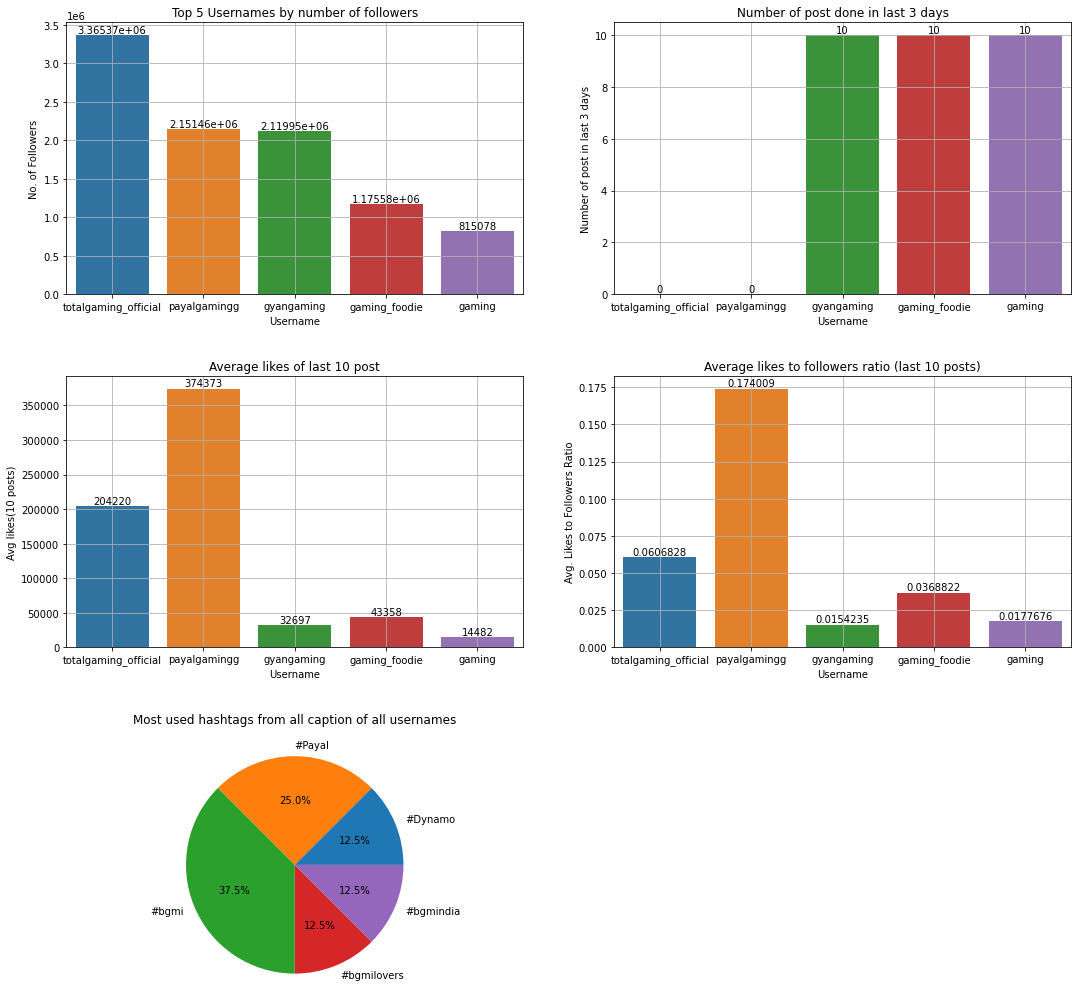

In [12]:
final_run()